In [1]:
from src.utils.data import getDataPandas, getConfigs
from src.dl.loader import PatchDataset, splitDataset
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import ConcatDataset

In [2]:
dataset = PatchDataset()

In [3]:
from src.dl.resnet import ModifiedResNet18

In [33]:
net = ModifiedResNet18().cuda()

In [5]:
from torch import nn
from torch.utils.data import DataLoader
import torch

In [34]:
loss_fn = nn.MSELoss().cuda()
lr = 1e-3
optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
#optim = torch.optim.Adam(net.parameters(), lr=lr)
epoch = 15
dataloader = DataLoader(dataset, 64)

In [7]:
train_sets, test_set = splitDataset(6000, 5, dataset)

In [8]:
train_set = ConcatDataset(train_sets[1:])
validate_set = train_sets[0]
train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
validate_dataloader = DataLoader(validate_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [9]:
len(validate_set)

6000

In [35]:
losslist = []

In [36]:
for i in range(epoch):
    net.train()
    for step, [img, labels, score] in enumerate(train_dataloader):
        img = img.cuda()
        labels = labels.cuda()
        score = score.cuda()
        output = net(img, labels).squeeze(-1)
        loss = loss_fn(output.float(), score.float())
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        train_step = len(dataloader) * i + step + 1
        if train_step % 100 == 0:
            print("train time {}, loss {}".format(train_step, loss.item()))
            losslist.append(loss.item())

train time 100, loss 0.09385241568088531
train time 200, loss 0.08549574017524719
train time 300, loss 0.07544465363025665
train time 700, loss 0.03667166084051132
train time 800, loss 0.0595109760761261
train time 900, loss 0.04251152276992798
train time 1000, loss 0.05516438186168671
train time 1300, loss 0.04452137276530266
train time 1400, loss 0.038172438740730286
train time 1500, loss 0.04551176726818085
train time 1600, loss 0.044829800724983215
train time 2000, loss 0.044425588101148605
train time 2100, loss 0.05761448293924332
train time 2200, loss 0.04938798397779465
train time 2300, loss 0.04412384331226349
train time 2600, loss 0.030469020828604698
train time 2700, loss 0.03913521021604538
train time 2800, loss 0.03993721678853035
train time 2900, loss 0.027992885559797287
train time 3300, loss 0.02562902867794037
train time 3400, loss 0.038402143865823746
train time 3500, loss 0.029997568577528
train time 3600, loss 0.029701296240091324
train time 3900, loss 0.040412072092

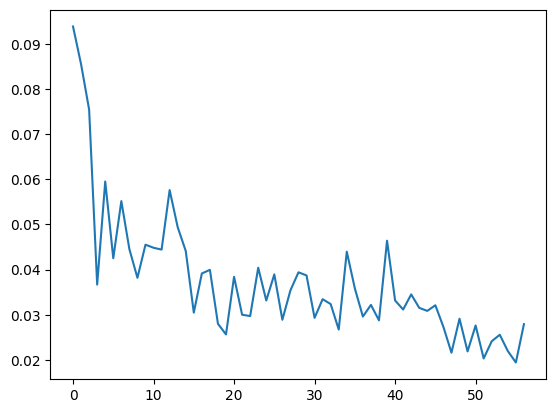

In [37]:
from matplotlib import pyplot as plt

plt.plot(losslist)

In [38]:
net.eval()
test_loss = 0
sum_gap = 0
avg_gap = 0
count = 0
with torch.no_grad():
    for img, labels, score in validate_dataloader:
        img = img.cuda()
        labels = labels.cuda()
        score = score.cuda()
        output = net(img, labels).squeeze(-1)
        loss = loss_fn(output.float(), score.float())
        test_loss += loss.item()
        #print(loss.item())
        sum_gap += np.sum(np.abs(output.cpu().numpy() - score.cpu().float().numpy()))
avg_gap = sum_gap / 6000
print(test_loss)
print(avg_gap)

3.664398856461048
0.1526143887042999
